# Set up notebook

In [1]:
%load_ext rpy2.ipython

## r libraries

In [2]:
%%R
library(dplyr)
library(Seurat)
library(patchwork)
library(data.table)
library(DropletUtils)
library(scRNAseq)
library(scater)
library(scran)
library(PCAtools)
set.seed(110010101)

path_to <- "VSG-2_VSG-6_2_count6/outs/"

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Attaching SeuratObject

R[write to console]: data.table 1.14.2 using 32 threads (see ?getDTthreads).  Latest news: r-datatable.com

R[write to console]: 
Attaching package: ‘data.table’


R[write to console]: The following objects are masked from ‘package:dplyr’:

    between, first, last


R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: MatrixGenerics

R[write to console]: Loading required package: matrixStats

R[write to console]: 
Attaching package: ‘matrixStats’


R[write to console]: The following object is masked from ‘package:dplyr’:

    count


R[write to console

## python libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy
import seaborn as sns

path_to = "VSG-2_VSG-6_2_count6/outs/"

## Estimate and remove Background

R[write to console]: Loading raw count data

R[write to console]: Loading cell-only count data

R[write to console]: Loading extra analysis data where available

R[write to console]: 7 genes passed tf-idf cut-off and 7 soup quantile filter.  Taking the top 7.

R[write to console]: Using 17 independent estimates of rho.

R[write to console]: Estimated global rho of 0.35

R[write to console]: Estimated contamination is very high (0.35).

R[write to console]: Expanding counts from 8 clusters to 5876 cells.



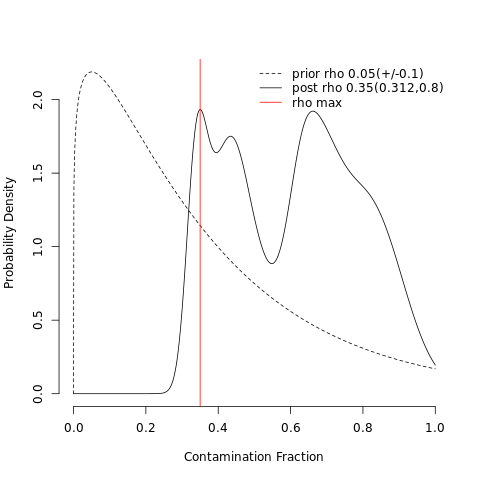

In [4]:
%%R
library(SoupX)
sce = load10X('VSG-2_VSG-6_2_count6/outs/')
sce = autoEstCont(sce, tfidfMin=0.75, forceAccept=TRUE)#, priorRhoStdDev = 0.3
out = adjustCounts(sce, roundToInt=TRUE)

In [5]:
%%R
head(sce$soupProfile[order(sce$soupProfile$est, decreasing = TRUE), ], n = 20)
#head(sce$soupProfile)

                             est counts
vsg-6-Tb427.BES15.12 0.033555219  39667
vsg-2-Tb427.BES40.22 0.021954234  25953
rRNA-Tb927.2.1975    0.013947575  16488
Tb927.1.2390         0.004562907   5394
Tb927.5.1810         0.002595291   3068
Tb927.3.3270         0.001758673   2079
Tb927.10.8940        0.001717223   2030
maxic-12S            0.001709610   2021
Tb11.v5.0632         0.001702843   2013
Tb11.v5.0498         0.001697767   2007
Tb11.v5.0381         0.001658855   1961
Tb11.1810b           0.001581876   1870
Tb927.11.9590        0.001484594   1755
Tb927.9.12570        0.001460909   1727
Tb927.2.370          0.001383084   1635
Tb927.6.560          0.001326407   1568
Tb927.5.810          0.001303567   1541
Tb927.6.4280         0.001263809   1494
rRNA-Tb927.6.187     0.001257887   1487
Tb927.10.14890       0.001254503   1483


In [6]:
#Tb927.1.2390 beta tubulin
#Tb927.1.2390 ysosomal/endosomal membrane protein p67
#Tb11.v5.0498 lysosomal alpha-mannosidase precursor, putative
#Tb927.10.8940 flagellum targeting protein kharon1, putative
#Tb927.3.3270 ATP-dependent 6-phosphofructokinase, glycosomal

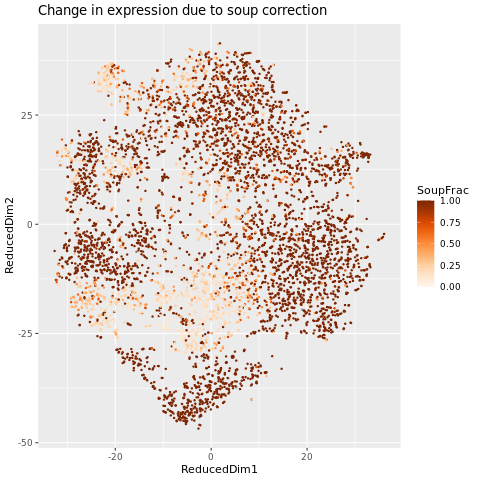

In [7]:
%%R
plotChangeMap(sce, out, "vsg-6-Tb427.BES15.12")

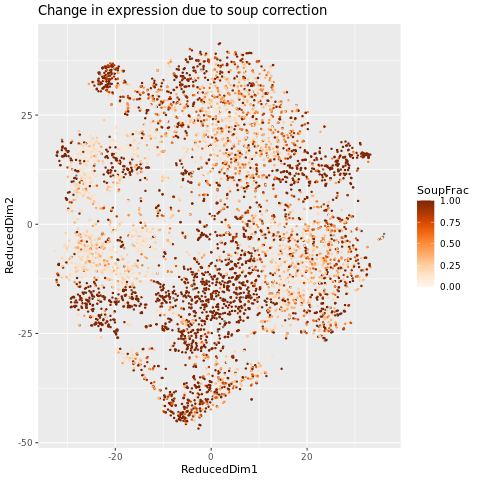

In [8]:
%%R
plotChangeMap(sce, out, "vsg-2-Tb427.BES40.22")

In [9]:
#%%R
#vsgGenes = c("vsg-6-Tb427.BES15.12", "vsg-2-Tb427.BES40.22")
#useToEst = estimateNonExpressingCells(sce, nonExpressedGeneList = list(vsgGenes = vsgGenes))
#sce = calculateContaminationFraction(sce, list(vsgGenes = vsgGenes), useToEst = useToEst)

In [10]:
#%%R
#sce = calculateContaminationFraction(sce, 
#                                     list(vsgGenes = vsgGenes), 
#                                     useToEst = useToEst, forceAccept=TRUE)

In [11]:
#%%R
#plotMarkerDistribution(sce)

# Load dataset

In [12]:
%%R
sce <- SingleCellExperiment(assays = list(counts = out))
sce

class: SingleCellExperiment 
dim: 11497 5876 
metadata(0):
assays(1): counts
rownames(11497): gene-Tb427.BES40.1 gene-Tb427.BES40.2 ... Tb11.1770
  Tb11.1800
rowData names(0):
colnames(5876): AAACCCAAGCGTGCTC-1 AAACCCACAATGGCAG-1 ...
  TTTGTTGCATAGCACT-1 TTTGTTGGTCCCGGTA-1
colData names(0):
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [13]:
%%R
assayNames(sce)

[1] "counts"


In [14]:
#%%R
#counts(sce) <- assay(sce, "decontXcounts")

# Add QC 
Default testing sum and detected transcripts plus:
- maxicircle
- ribosomal RNA
- VSGs

In [15]:
%%R
is.mito <- grepl("^maxic", rownames(sce))
is.vsg <- grepl("^vsg-", rownames(sce))
is.Ribo <-grepl("^rRNA-", rownames(sce)) 
df <- perCellQCMetrics(counts(sce), subsets=list(Mito=is.mito, VSG=is.vsg, Ribo=is.Ribo))
head(df)

DataFrame with 6 rows and 11 columns
                         sum  detected subsets_Mito_sum subsets_Mito_detected
                   <numeric> <integer>        <numeric>             <integer>
AAACCCAAGCGTGCTC-1       541       383                2                     2
AAACCCACAATGGCAG-1       472       354                6                     4
AAACCCACAGAACCGA-1       669       483                1                     1
AAACCCACATGCCATA-1       451       341                8                     4
AAACCCAGTAACCAGG-1       580       444               14                     3
AAACCCATCACTAGCA-1       443       393                8                     4
                   subsets_Mito_percent subsets_VSG_sum subsets_VSG_detected
                              <numeric>       <numeric>            <integer>
AAACCCAAGCGTGCTC-1             0.369686              51                    1
AAACCCACAATGGCAG-1             1.271186              32                    1
AAACCCACAGAACCGA-1             

In [16]:
%%R
sum(is.Ribo)

[1] 104


# Test x outlayers

In [17]:
%%R
# not too high / not too low
qc.lib2 <- isOutlier(df$sum, nmads = 2, log=TRUE, type="both")
qc.nexprs2 <- isOutlier(df$detected, nmads = 2, log=TRUE, type="both")
qc.vsg2 <- isOutlier(df$subsets_VSG_percent, nmads = 2, type="both")

# not too high
qc.mito2 <- isOutlier(df$subsets_Mito_percent, nmads = 3, type="higher")
qc.ribo2 <- isOutlier(df$subsets_Ribo_percent, nmads = 3, type="higher")

discard2 <- qc.lib2 | qc.nexprs2 | qc.mito2 | qc.ribo2 | qc.vsg2
sum(discard2)

[1] 994


## add discarded info to the sce object

In [18]:
%R sce$discard_mito <- qc.mito2
%R sce$discard_sum <- qc.lib2
%R sce$discard_detect <- qc.nexprs2
%R sce$discard_vsg <- qc.vsg2
%R sce$discard_ribo <- qc.ribo2
%R sce$discard_all <- discard2

0,0,0,...,0,0,0


## quick add qc to sce

In [19]:
%%R
sce <- addPerCellQC(sce, subsets=list(Mito=is.mito, VSG=is.vsg, Ribo=is.Ribo))
sce

class: SingleCellExperiment 
dim: 11497 5876 
metadata(0):
assays(1): counts
rownames(11497): gene-Tb427.BES40.1 gene-Tb427.BES40.2 ... Tb11.1770
  Tb11.1800
rowData names(0):
colnames(5876): AAACCCAAGCGTGCTC-1 AAACCCACAATGGCAG-1 ...
  TTTGTTGCATAGCACT-1 TTTGTTGGTCCCGGTA-1
colData names(18): discard_mito discard_sum ... subsets_Ribo_percent
  total
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


## Visualize Discarded
### by mito

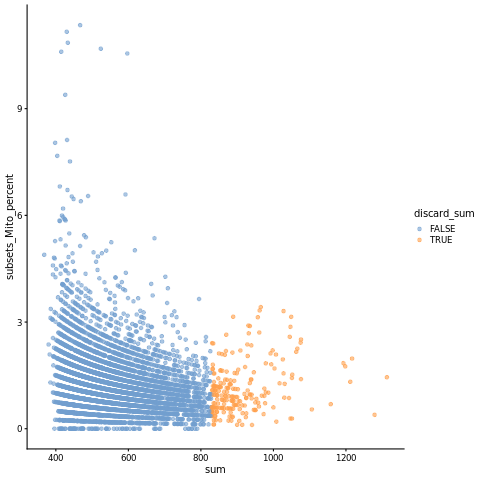

In [20]:
%%R
plotColData(sce, x="sum", y="subsets_Mito_percent", colour_by="discard_sum")

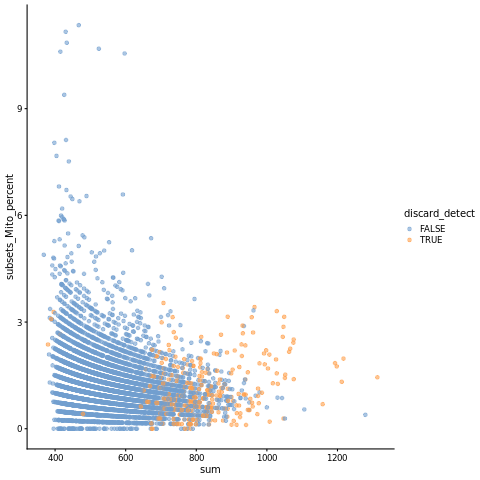

In [21]:
%%R
plotColData(sce, x="sum", y="subsets_Mito_percent", colour_by="discard_detect")

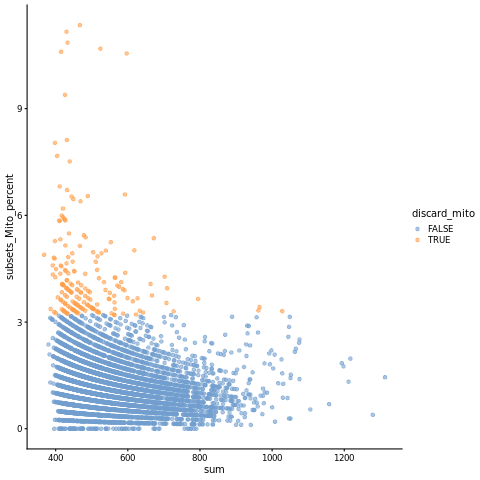

In [22]:
%%R
plotColData(sce, x="sum", y="subsets_Mito_percent", colour_by="discard_mito")

In [23]:
#%%R
#plotColData(sce, x="sum", y="subsets_Mito_percent", colour_by="discard_vsg")

In [24]:
#%%R
#plotColData(sce, x="sum", y="subsets_Mito_percent", colour_by="discard_ribo")

### by VSG

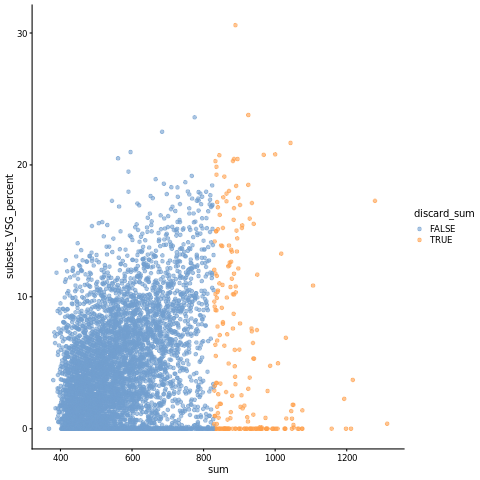

In [25]:
%%R
plotColData(sce, x="sum", y="subsets_VSG_percent", colour_by="discard_sum")

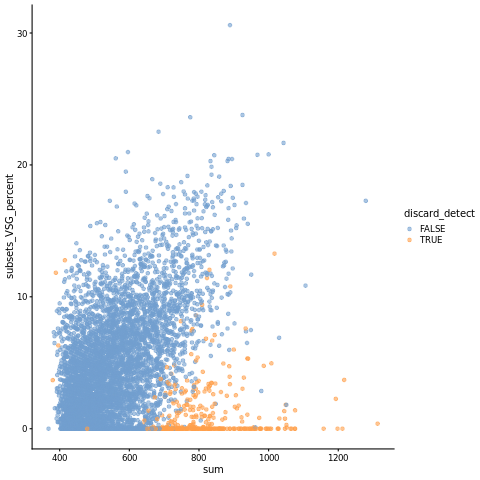

In [26]:
%%R
plotColData(sce, x="sum", y="subsets_VSG_percent", colour_by="discard_detect")

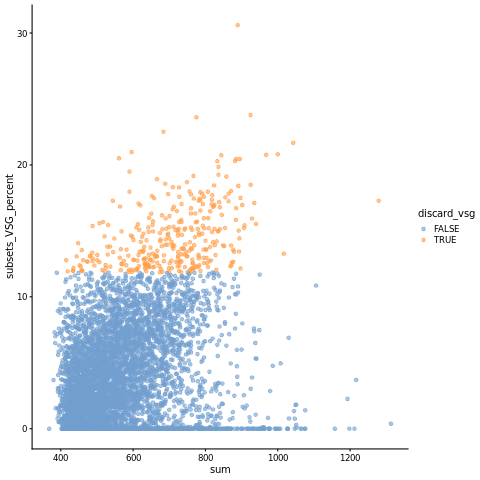

In [27]:
%%R
plotColData(sce, x="sum", y="subsets_VSG_percent", colour_by="discard_vsg")

In [28]:
#%%R
#plotColData(sce, x="sum", y="subsets_VSG_percent", colour_by="discard_mito")

In [29]:
#%%R
#plotColData(sce, x="sum", y="subsets_VSG_percent", colour_by="discard_ribo")

### by Ribo

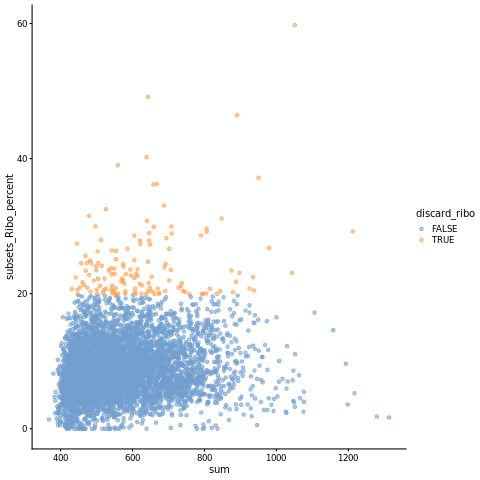

In [30]:
%%R
plotColData(sce, x="sum", y="subsets_Ribo_percent", colour_by="discard_ribo")

### all

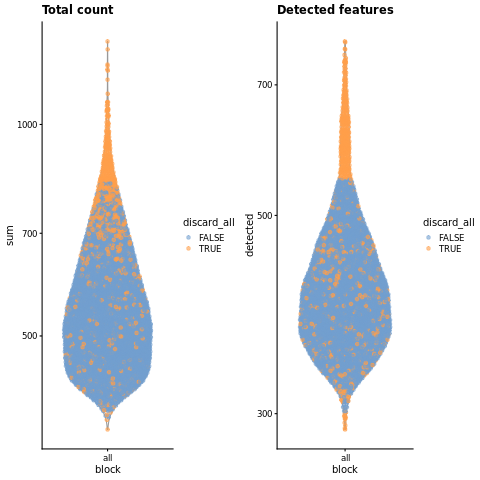

In [31]:
%%R
#colData(sce.416b) <- cbind(colData(sce.416b), df)
sce$block <- factor(rep('all',nrow(df)))


gridExtra::grid.arrange(
    plotColData(sce, x="block", y="sum", colour_by="discard_all") + 
        scale_y_log10() + ggtitle("Total count"),
    plotColData(sce, x="block", y="detected", colour_by="discard_all")+
        scale_y_log10() + ggtitle("Detected features"),
    
    #plotColData(sce, x="block", y="subsets_Mito_percent", colour_by="discard_all")+
    #    scale_y_log10() + ggtitle("Detected features"),


    
    nrow=1
    
)

In [32]:
#%%R
#library(repr)
#fig <- function(){
#    par(mfrow=c(1,2))
#    #options(repr.plot.width = 12, repr.plot.height = 3)
#    hist(
#        sce$total,
#        breaks = 100)
    
#    hist(
#        sce$detected,
#        breaks = 100)
    
# }
#fig()

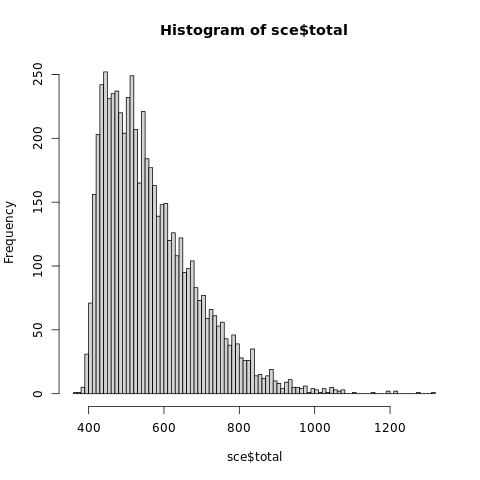

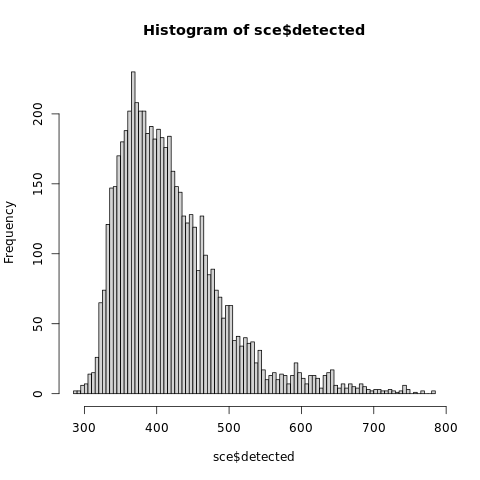

In [33]:
%%R

hist(
    sce$total,
    breaks = 100)

hist(
    sce$detected,
    breaks = 100)

In [34]:
#%%R
#min(sce$total)

# Library size before filtering

In [35]:
%%R
lib.size <- librarySizeFactors(sce)
summary(lib.size)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.6499  0.8335  0.9536  1.0000  1.1196  2.3187 


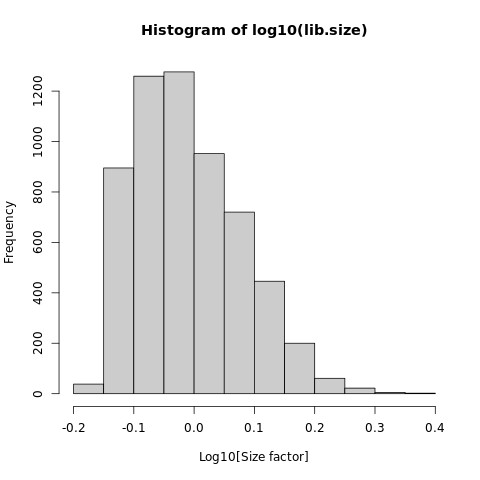

In [36]:
%%R
hist(log10(lib.size), xlab="Log10[Size factor]", col='grey80')

# Library size after filtering

In [37]:
%%R
sce <- sce[, which(!discard2)]
sce

class: SingleCellExperiment 
dim: 11497 4882 
metadata(0):
assays(1): counts
rownames(11497): gene-Tb427.BES40.1 gene-Tb427.BES40.2 ... Tb11.1770
  Tb11.1800
rowData names(0):
colnames(4882): AAACCCAAGCGTGCTC-1 AAACCCACAATGGCAG-1 ...
  TTTGTTGCATAGCACT-1 TTTGTTGGTCCCGGTA-1
colData names(19): discard_mito discard_sum ... total block
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [38]:
%%R
lib.size <- librarySizeFactors(sce)
summary(lib.size)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.7090  0.8663  0.9700  1.0000  1.1088  1.5327 


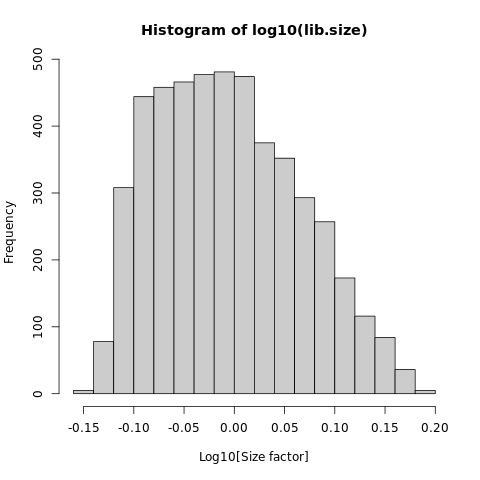

In [39]:
%%R
hist(log10(lib.size), xlab="Log10[Size factor]", col='grey80')

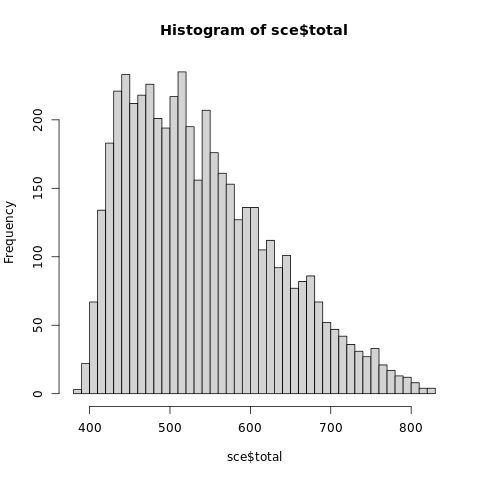

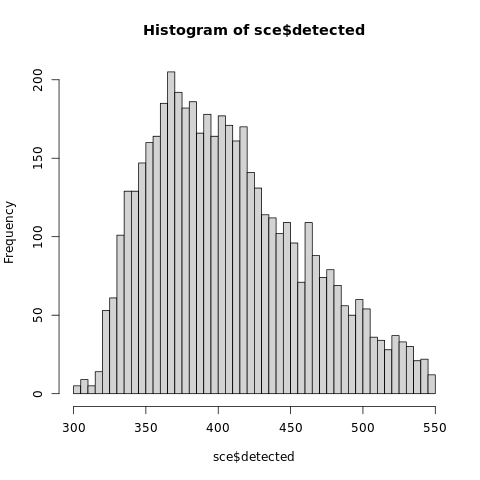

In [40]:
%%R
hist(
    sce$total,
    breaks = 50)

hist(
    sce$detected,
    breaks = 50)

In [41]:
%%R
assayNames(sce)

[1] "counts"


# Adjust for library size

In [42]:
%%R
clust.sce <- quickCluster(sce)
sce <- computeSumFactors(sce, cluster=clust.sce, min.mean=0.1)
sce <- logNormCounts(sce)
assayNames(sce)

[1] "counts"    "logcounts"


# Visualize CV

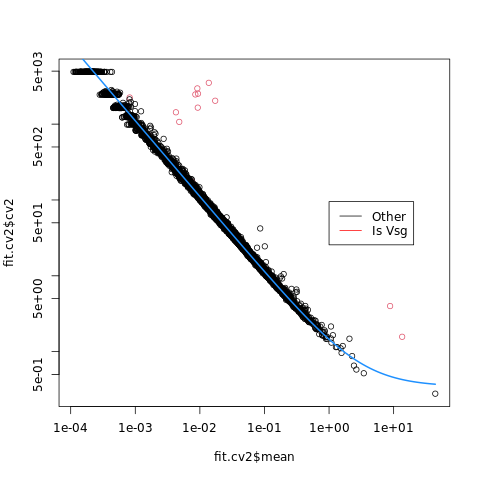

In [43]:
%%R
is.vsg2 <- grepl("^vsg-", rownames(sce))
length(is.vsg2)

dec.cv2 <- modelGeneCV2(sce)
fit.cv2 <- metadata(dec.cv2)
plot(fit.cv2$mean, fit.cv2$cv2, log="xy", col=is.vsg2+1)
curve(fit.cv2$trend(x), col="dodgerblue", add=TRUE, lwd=2)
legend(1, 95, legend=c("Other", "Is Vsg"),col=c("black", "red"),lty=1:1)

# Poisson Modeling

In [44]:
%%R 
dec.pois <- modelGeneVarByPoisson(sce)
dec.pois <- dec.pois[order(dec.pois$bio, decreasing=TRUE),]
head(dec.pois)

DataFrame with 6 rows and 6 columns
                          mean     total      tech       bio      p.value
                     <numeric> <numeric> <numeric> <numeric>    <numeric>
vsg-2-Tb427.BES40.22   2.49978  4.868728 0.3688343  4.499893  0.00000e+00
vsg-6-Tb427.BES15.12   1.32689  4.683313 0.5893168  4.093997  0.00000e+00
rRNA-Tb927.2.1975      5.26917  0.826888 0.0573352  0.769553  0.00000e+00
Tb927.1.2390           1.21425  1.129764 0.5921163  0.537647 1.20492e-259
Tb11.v5.0632           1.41021  0.915706 0.5831443  0.332562 7.82973e-104
maxic-12S              1.90045  0.828824 0.5026954  0.326129 1.05194e-133
                              FDR
                        <numeric>
vsg-2-Tb427.BES40.22  0.00000e+00
vsg-6-Tb427.BES15.12  0.00000e+00
rRNA-Tb927.2.1975     0.00000e+00
Tb927.1.2390         9.09414e-257
Tb11.v5.0632         4.43212e-101
maxic-12S            6.35164e-131


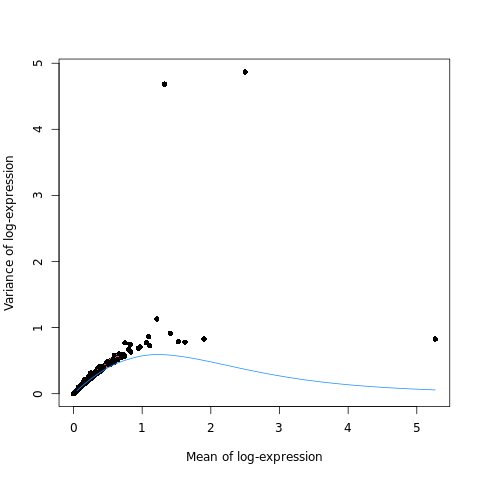

In [45]:
%%R 
plot(dec.pois$mean, dec.pois$total, pch=16, xlab="Mean of log-expression",
    ylab="Variance of log-expression", col=is.vsg2+1)
curve(metadata(dec.pois)$trend(x), col="dodgerblue", add=TRUE)

# Select top variable

In [46]:
%%R 
hvg.var <- getTopHVGs(dec.pois, fdr.threshold=0.000000001)
length(hvg.var)

[1] 490


# Dimensionality Reduction

In [47]:
%%R 
head(hvg.var)

[1] "vsg-2-Tb427.BES40.22" "vsg-6-Tb427.BES15.12" "rRNA-Tb927.2.1975"   
[4] "Tb927.1.2390"         "Tb11.v5.0632"         "maxic-12S"           


In [48]:
#%%R
##to install
##https://bioconductor.org/books/release/OSCA/dimensionality-reduction.html#overview-2
#percent.var <- attr(reducedDim(sce), "percentVar")
#chosen.elbow <- PCAtools::findElbowPoint(percent.var)
#chosen.elbow

In [49]:
%%R
sce <- runPCA(sce, subset_row=hvg.var) 
reducedDimNames(sce)

[1] "PCA"


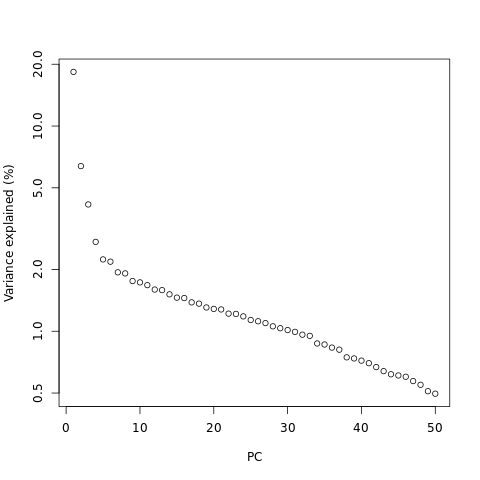

In [50]:
%%R 
percent.var <- attr(reducedDim(sce), "percentVar")
plot(percent.var, log="y", xlab="PC", ylab="Variance explained (%)")

In [51]:
%%R 
# Percentage of variance explained is tucked away in the attributes.
percent.var <- attr(reducedDim(sce), "percentVar")
chosen.elbow <- PCAtools::findElbowPoint(percent.var)
chosen.elbow

[1] 5


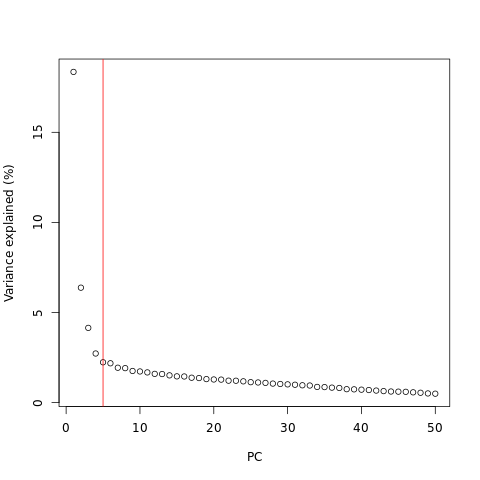

In [52]:
%%R
plot(percent.var, xlab="PC", ylab="Variance explained (%)")
abline(v=chosen.elbow, col="red")

In [53]:
%%R
sce <- runPCA(sce, subset_row=hvg.var, ncomponents = 5)

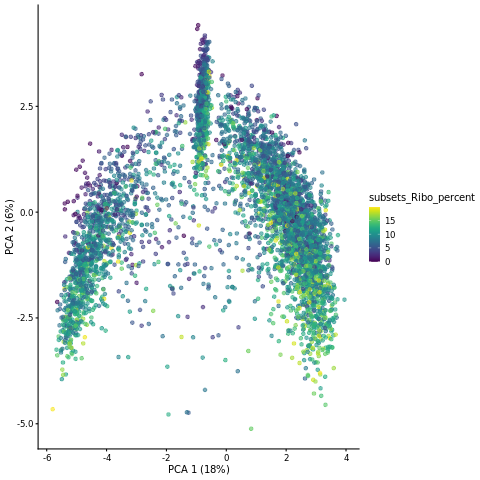

In [54]:
%%R
plotReducedDim(sce, dimred="PCA", colour_by="subsets_Ribo_percent")

In [55]:
#%%R 
#sce <- runTSNE(sce, dimred="PCA", perplexity=200)
#plotReducedDim(sce, dimred="TSNE", colour_by="subsets_Mito_percent")

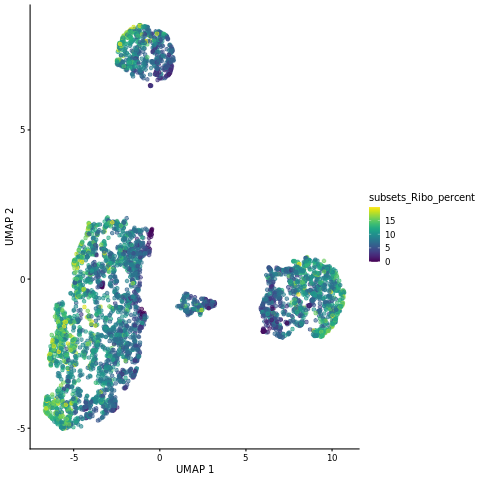

In [56]:
%%R
sce <- runUMAP(sce, dimred="PCA")
plotReducedDim(sce, dimred="UMAP", colour_by="subsets_Ribo_percent")

In [57]:
%%R
clust.kmeans <- kmeans(reducedDim(sce, "UMAP"), centers=3)
table(clust.kmeans$cluster)


   1    2    3 
2882  691 1309 


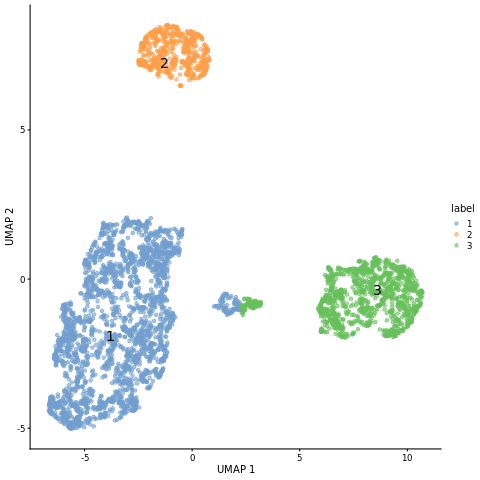

In [58]:
%%R
colLabels(sce) <- factor(clust.kmeans$cluster)
plotReducedDim(sce, "UMAP", colour_by="label",text_by="label")

R[write to console]: 
Attaching package: 'celda'


R[write to console]: The following objects are masked from 'package:scater':

    normalizeCounts, plotHeatmap


R[write to console]: The following object is masked from 'package:scuttle':

    normalizeCounts


R[write to console]: The following object is masked from 'package:S4Vectors':

    params




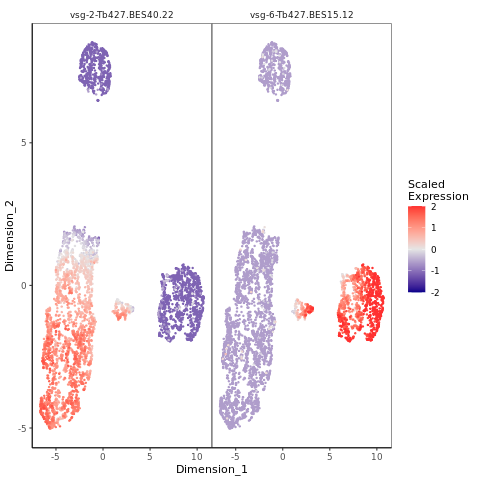

In [59]:
%%R
library(celda)
umap <- reducedDim(sce, "UMAP")
plotDimReduceFeature(as.matrix(logcounts(sce)),
    dim1 = umap[, 1],
    dim2 = umap[, 2],
    features = c('vsg-2-Tb427.BES40.22', 'vsg-6-Tb427.BES15.12'),
    exactMatch = TRUE)



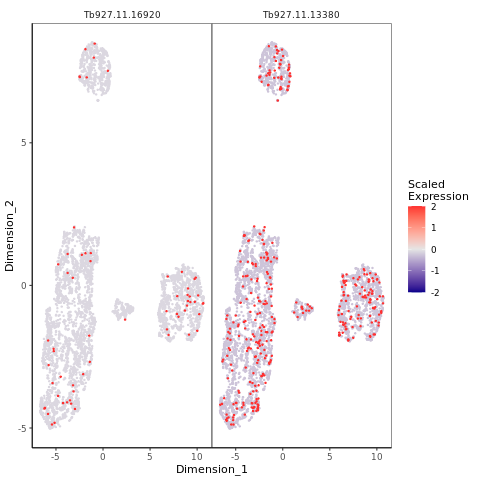

In [60]:
%%R
library(celda)
umap <- reducedDim(sce, "UMAP")
plotDimReduceFeature(as.matrix(logcounts(sce),zscore=FALSE),
    dim1 = umap[, 1],
    dim2 = umap[, 2],
    features = c('Tb927.11.16920', 'Tb927.11.13380'),
    exactMatch = TRUE)

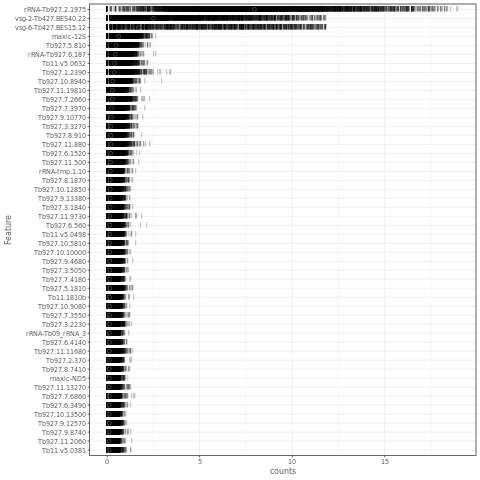

In [61]:
%%R
plotHighestExprs(sce, exprs_values = "counts")

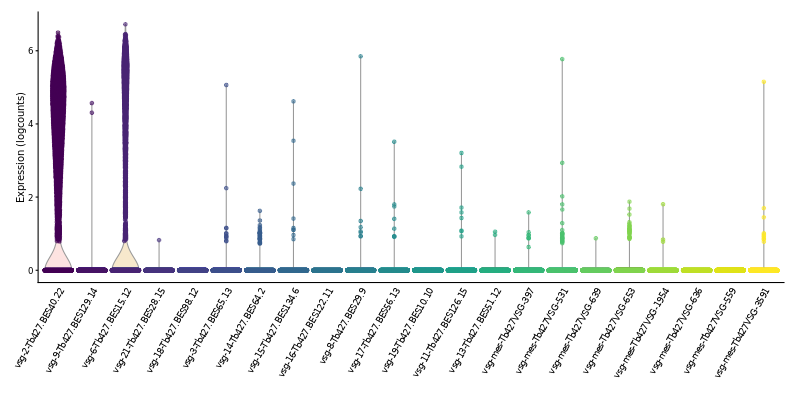

In [62]:
%%R -w 800 -h 400

names = c('vsg-2-Tb427.BES40.22', 
          'vsg-6-Tb427.BES15.12',
          
          'Tb927.11.16920', 
          'Tb927.11.13380')

plotExpression(sce, rownames(sce[which(is.vsg2), ]))

In [72]:
%%R
sce

class: SingleCellExperiment 
dim: 11497 4882 
metadata(0):
assays(2): counts logcounts
rownames(11497): gene-Tb427.BES40.1 gene-Tb427.BES40.2 ... Tb11.1770
  Tb11.1800
rowData names(0):
colnames(4882): AAACCCAAGCGTGCTC-1 AAACCCACAATGGCAG-1 ...
  TTTGTTGCATAGCACT-1 TTTGTTGGTCCCGGTA-1
colData names(21): discard_mito discard_sum ... sizeFactor label
reducedDimNames(2): PCA UMAP
mainExpName: NULL
altExpNames(0):


In [74]:
%%R
is.vsg2 <- grepl("^vsg-2-", rownames(sce))
is.vsg6 <- grepl("^vsg-6-", rownames(sce))
sce <- addPerCellQC(sce, subsets=list(VSG2=is.vsg2, VSG6=is.vsg6))
sce

class: SingleCellExperiment 
dim: 11497 4882 
metadata(0):
assays(2): counts logcounts
rownames(11497): gene-Tb427.BES40.1 gene-Tb427.BES40.2 ... Tb11.1770
  Tb11.1800
rowData names(0):
colnames(4882): AAACCCAAGCGTGCTC-1 AAACCCACAATGGCAG-1 ...
  TTTGTTGCATAGCACT-1 TTTGTTGGTCCCGGTA-1
colData names(30): discard_mito discard_sum ... subsets_VSG6_percent
  total
reducedDimNames(2): PCA UMAP
mainExpName: NULL
altExpNames(0):


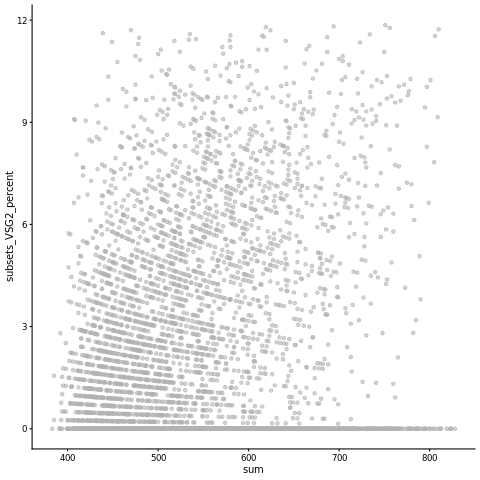

In [75]:
%%R
plotColData(sce, x="sum", y="subsets_VSG2_percent")

In [84]:
%%R
#df$subsets_VSG6_percent>3

   [1] FALSE  TRUE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [13] FALSE FALSE FALSE FALSE FALSE FALSE  TRUE FALSE  TRUE FALSE FALSE FALSE
  [25] FALSE FALSE FALSE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE  TRUE FALSE
  [37]  TRUE FALSE FALSE FALSE  TRUE FALSE  TRUE FALSE  TRUE  TRUE FALSE FALSE
  [49] FALSE FALSE FALSE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE
  [61]  TRUE  TRUE FALSE FALSE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE
  [73] FALSE FALSE FALSE FALSE FALSE FALSE  TRUE FALSE  TRUE FALSE FALSE FALSE
  [85]  TRUE FALSE FALSE  TRUE FALSE  TRUE FALSE FALSE FALSE  TRUE FALSE  TRUE
  [97] FALSE FALSE FALSE FALSE  TRUE FALSE  TRUE  TRUE FALSE FALSE FALSE FALSE
 [109] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [121]  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE FALSE FALSE
 [133] FALSE FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE FALSE  TRUE FALSE FALSE
 [145]  TRUE FALSE FALSE FALSE FALSE  TRUE FALSE FAL

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [88]:
%%R
df <- perCellQCMetrics(counts(sce), subsets=list(VSG2=is.vsg2, VSG6=is.vsg6))
#qc.VSG6 <- isOutlier(df$subsets_VSG6_percent, nmads = 0.1, type="lower")
#qc.VSG2 <- isOutlier(df$subsets_VSG2_percent, nmads = 0.1, type="lower")
sce$discard_VSG6 <- df$subsets_VSG6_percent<3
sce$discard_VSG2 <- df$subsets_VSG2_percent<3
sce$discard_VSG2_VSG6 <- sce$discard_VSG6 & sce$discard_VSG2
#sce$discard_VSG2_VSG6_zero <- df$subsets_VSG2_percent == 0 & df$subsets_VSG2_percent

head(df)

DataFrame with 6 rows and 8 columns
                         sum  detected subsets_VSG2_sum subsets_VSG2_detected
                   <numeric> <integer>        <numeric>             <integer>
AAACCCAAGCGTGCTC-1       541       383               51                     1
AAACCCACAATGGCAG-1       472       354                0                     0
AAACCCACAGAACCGA-1       669       483               52                     1
AAACCCACATGCCATA-1       451       341               13                     1
AAACCCAGTAACCAGG-1       580       444                0                     0
AAACCCATCACTAGCA-1       443       393                3                     1
                   subsets_VSG2_percent subsets_VSG6_sum subsets_VSG6_detected
                              <numeric>        <numeric>             <integer>
AAACCCAAGCGTGCTC-1             9.426987                0                     0
AAACCCACAATGGCAG-1             0.000000               32                     1
AAACCCACAGAACCGA-1      

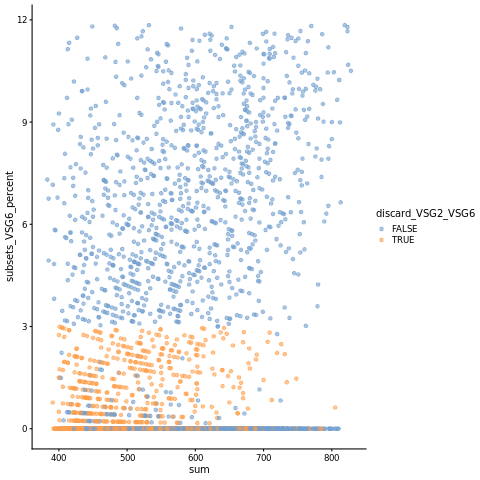

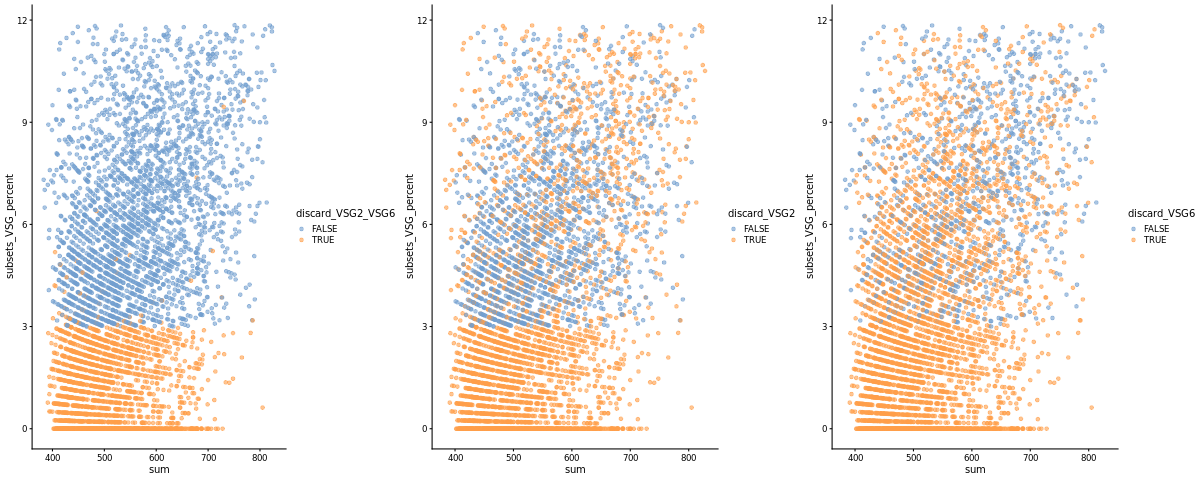

In [100]:
%%R -w 1200
gridExtra::grid.arrange(
    
plotColData(sce, x="sum", y="subsets_VSG_percent",colour_by="discard_VSG2_VSG6"),
plotColData(sce, x="sum", y="subsets_VSG_percent",colour_by="discard_VSG2"),    
plotColData(sce, x="sum", y="subsets_VSG_percent",colour_by="discard_VSG6"),      
  nrow=1  
)

In [101]:
%%R
sce_selection <- sce[, which(!sce$discard_VSG2_VSG6)]
sce_selection

class: SingleCellExperiment 
dim: 11497 2606 
metadata(0):
assays(2): counts logcounts
rownames(11497): gene-Tb427.BES40.1 gene-Tb427.BES40.2 ... Tb11.1770
  Tb11.1800
rowData names(0):
colnames(2606): AAACCCAAGCGTGCTC-1 AAACCCACAATGGCAG-1 ...
  TTTGTTGAGTCGGCCT-1 TTTGTTGCATAGCACT-1
colData names(33): discard_mito discard_sum ... discard_VSG2
  discard_VSG2_VSG6
reducedDimNames(2): PCA UMAP
mainExpName: NULL
altExpNames(0):


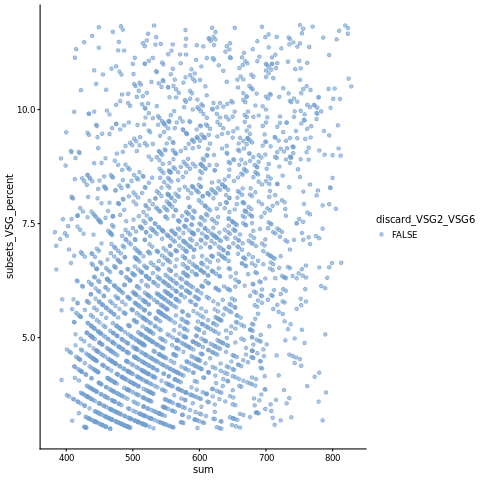

In [103]:
%%R
plotColData(sce_selection, x="sum", y="subsets_VSG_percent",colour_by="discard_VSG2_VSG6")

In [105]:
%%R
sce_selection <- SingleCellExperiment(assays = list(counts = counts(sce_selection)))
clust.sce <- quickCluster(sce_selection)
sce_selection <- computeSumFactors(sce_selection, cluster=clust.sce, min.mean=0.1)
sce_selection <- logNormCounts(sce_selection)
assayNames(sce_selection)


[1] "counts"    "logcounts"


In [106]:
%%R 
dec.pois <- modelGeneVarByPoisson(sce_selection)
dec.pois <- dec.pois[order(dec.pois$bio, decreasing=TRUE),]
head(dec.pois)

DataFrame with 6 rows and 6 columns
                          mean     total      tech       bio      p.value
                     <numeric> <numeric> <numeric> <numeric>    <numeric>
vsg-6-Tb427.BES15.12   2.04716  6.597213 0.4679511  6.129262  0.00000e+00
vsg-2-Tb427.BES40.22   3.23347  5.925130 0.2298137  5.695316  0.00000e+00
rRNA-Tb927.2.1975      5.39421  0.810460 0.0521505  0.758309  0.00000e+00
Tb927.1.2390           1.46223  1.221627 0.5772310  0.644396 3.36869e-262
Tb11.v5.0632           1.47523  0.958465 0.5755260  0.382939  1.22650e-94
maxic-12S              1.89992  0.833502 0.5002185  0.333284  6.87613e-95
                              FDR
                        <numeric>
vsg-6-Tb427.BES15.12  0.00000e+00
vsg-2-Tb427.BES40.22  0.00000e+00
rRNA-Tb927.2.1975     0.00000e+00
Tb927.1.2390         7.44566e-259
Tb11.v5.0632          1.54906e-91
maxic-12S             1.01320e-91


In [108]:
%%R 
hvg.var <- getTopHVGs(dec.pois,n=200)#,fdr.threshold=0.00001)#, fdr.threshold=0.000000001)
length(hvg.var)

[1] 200


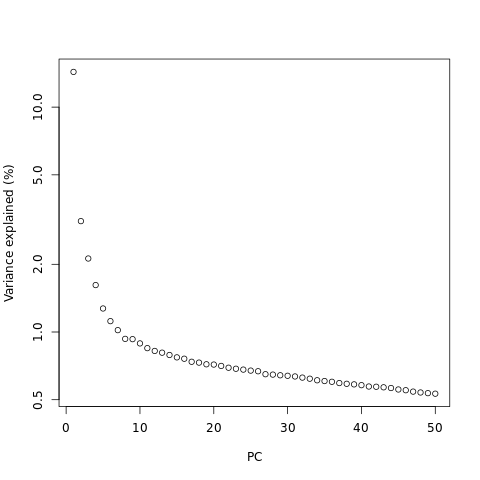

In [109]:
%%R
#rownames(sce[which(is.vsg2)])
sce_selection <- runPCA(sce_selection, subset_row=hvg.var) 
percent.var <- attr(reducedDim(sce_selection), "percentVar")
plot(percent.var, log="y", xlab="PC", ylab="Variance explained (%)")


In [110]:
%%R
#rownames(sce[which(is.vsg2), ]
sce_selection <- runPCA(sce_selection, subset_row=hvg.var, ncomponents = 10)

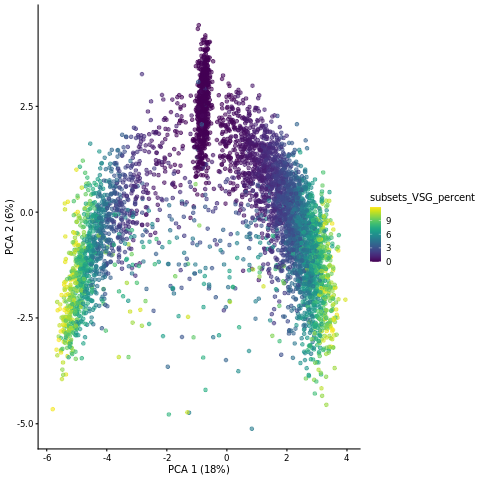

In [122]:
%%R
is.vsg <- grepl("^vsg-", rownames(sce_selection))
sce_selection <- addPerCellQC(sce_selection,subsets=list(VSG=is.vsg, VSG2=is.vsg2, VSG6=is.vsg6))
plotReducedDim(sce, dimred="PCA", colour_by="subsets_VSG_percent")

In [116]:
%%R
nn.clusters <- clusterCells(sce_selection, use.dimred="PCA")
table(nn.clusters)

nn.clusters
  1   2   3   4   5   6 
683 719 449 463 256  36 


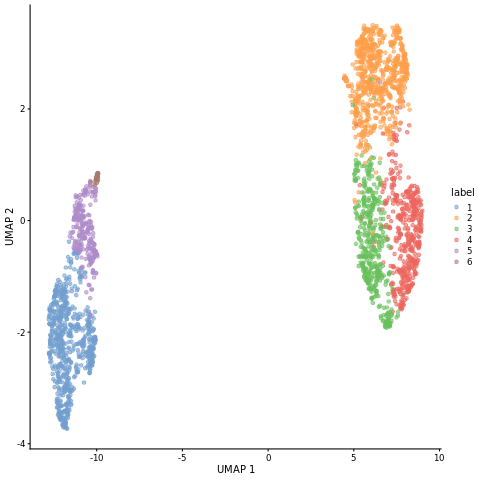

In [120]:
%%R
colLabels(sce_selection) <- nn.clusters
sce_selection <- runUMAP(sce_selection, dimred="PCA")
plotReducedDim(sce_selection, "UMAP", colour_by="label")

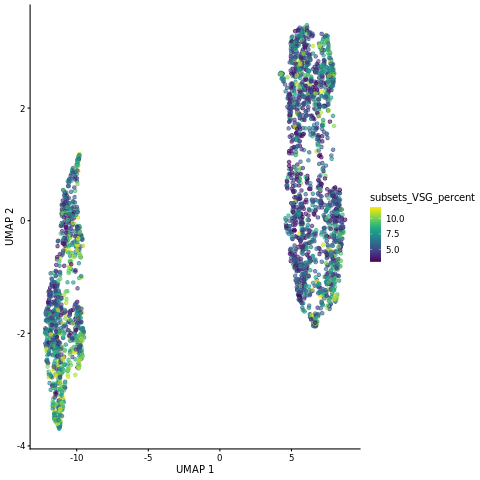

In [121]:
%%R
colLabels(sce_selection) <- nn.clusters
sce_selection <- runUMAP(sce_selection, dimred="PCA")
plotReducedDim(sce_selection, "UMAP", colour_by="subsets_VSG_percent")

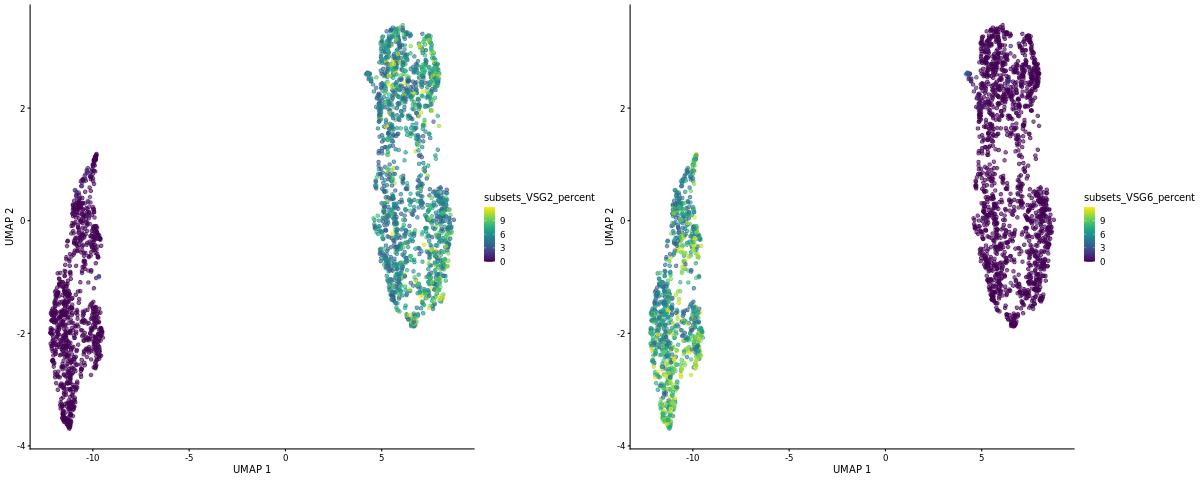

In [124]:
%%R -w 1200
gridExtra::grid.arrange(
    plotReducedDim(sce_selection, "UMAP", colour_by="subsets_VSG2_percent"),
    plotReducedDim(sce_selection, "UMAP", colour_by="subsets_VSG6_percent"),
    nrow=1
    )

In [126]:
%%R
clust.kmeans <- kmeans(reducedDim(sce_selection, "UMAP"), centers=2)
table(clust.kmeans$cluster)


   1    2 
1632  974 


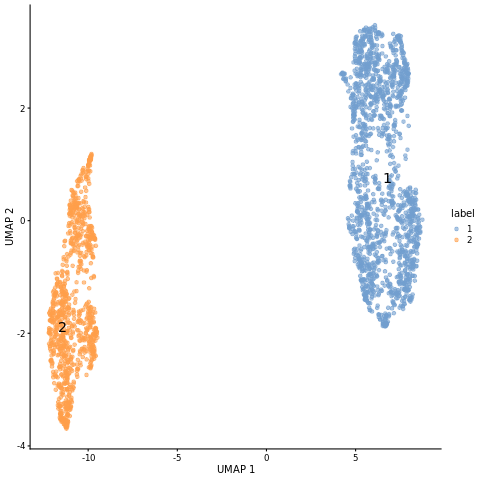

In [128]:
%%R
colLabels(sce_selection) <- factor(clust.kmeans$cluster)
plotReducedDim(sce_selection, "UMAP", colour_by="label",text_by="label")

In [129]:
%%R
marker.info <- scoreMarkers(sce_selection, colLabels(sce_selection))
marker.info

List of length 2
names(2): 1 2


In [137]:
%%R
chosen <- marker.info[["1"]]
ordered <- chosen[order(chosen$mean.AUC, decreasing=TRUE),]
head(ordered[,1:4],n=10) # showing basic stats only, for brevity.

DataFrame with 10 rows and 4 columns
                     self.average other.average self.detected other.detected
                        <numeric>     <numeric>     <numeric>      <numeric>
vsg-2-Tb427.BES40.22     5.058302     0.1758377      1.000000      0.0852156
gene-Tb427.BES40.3       0.318476     0.0255616      0.240809      0.0246407
Tb927.5.810              1.750236     1.5492280      0.871936      0.8439425
gene-Tb427.BES40.1       0.197292     0.0208862      0.157475      0.0184805
Tb927.10.12850           0.796407     0.6086532      0.563725      0.4671458
Tb927.11.10330           0.291058     0.1310694      0.244485      0.1170431
Tb927.10.10000           0.681399     0.5112056      0.490809      0.3963039
Tb927.7.5940             0.445775     0.3067847      0.348652      0.2597536
Tb927.7.2660             1.143005     0.9991006      0.693627      0.6416838
Tb927.1.100              0.339641     0.2305963      0.288603      0.2053388


In [138]:
%%R
write.csv(ordered,
          file=paste(path_to,"ordered_1.csv",sep=''), 
          row.names = TRUE)

In [136]:
%%R
chosen <- marker.info[["2"]]
ordered <- chosen[order(chosen$mean.AUC, decreasing=TRUE),]
head(ordered[,1:4],n=10) # showing basic stats only, for brevity.

DataFrame with 10 rows and 4 columns
                     self.average other.average self.detected other.detected
                        <numeric>     <numeric>     <numeric>      <numeric>
vsg-6-Tb427.BES15.12     5.294682     0.1089946      1.000000      0.0484069
Tb927.3.3270             1.179100     0.8337589      0.690965      0.5373775
Tb927.9.4680             0.895755     0.6106921      0.619097      0.4632353
Tb11.v5.0632             1.659017     1.3655379      0.833676      0.7555147
Tb927.11.880             1.096740     0.8079164      0.646817      0.5104167
Tb927.10.14140           0.368962     0.1372622      0.278234      0.1182598
Tb927.6.4280             0.494022     0.2600635      0.338809      0.1979167
Tb927.3.4090             0.548377     0.3520480      0.399384      0.2689951
gene-Tb427.BES15.2       0.171759     0.0147913      0.146817      0.0134804
Tb927.11.7510            0.630097     0.4389353      0.471253      0.3498775


In [63]:
%%R
length(colLabels(sce))

[1] 4882


In [64]:
%%R
marker.info <- scoreMarkers(sce, colLabels(sce))
marker.info

List of length 3
names(3): 1 2 3


In [65]:
%%R
chosen <- marker.info[["1"]]
ordered <- chosen[order(chosen$mean.AUC, decreasing=TRUE),]
head(ordered[,1:10]) # showing basic stats only, for brevity.

DataFrame with 6 rows and 10 columns
                     self.average other.average self.detected other.detected
                        <numeric>     <numeric>     <numeric>      <numeric>
vsg-2-Tb427.BES40.22     4.115096     0.1355143      0.998265      0.0663607
gene-Tb427.BES40.3       0.312334     0.1066518      0.244622      0.0870352
Tb927.5.810              1.703583     1.4999896      0.871270      0.8219214
gene-Tb427.BES40.1       0.210909     0.0737202      0.171756      0.0614675
rRNA-Tb927.2.1975        5.339918     5.1655360      0.994795      0.9946928
Tb927.10.12850           0.769629     0.6251233      0.553435      0.4719884
                     mean.logFC.cohen min.logFC.cohen median.logFC.cohen
                            <numeric>       <numeric>          <numeric>
vsg-2-Tb427.BES40.22         4.130787        3.678132           4.130787
gene-Tb427.BES40.3           0.443345        0.258524           0.443345
Tb927.5.810                  0.229952        0.199872  

In [66]:
%%R
chosen <- marker.info[["2"]]
ordered <- chosen[order(chosen$mean.AUC, decreasing=TRUE),]
head(ordered[,1:2]) # showing basic stats only, for brevity.

DataFrame with 6 rows and 2 columns
               self.average other.average
                  <numeric>     <numeric>
Tb927.6.1520       0.969726     0.7413611
Tb927.3.2230       0.715303     0.5460603
Tb927.10.6730      0.242150     0.1059708
Tb927.8.3770       0.582174     0.4273825
Tb927.10.10260     0.230726     0.0654171
Tb927.6.510        0.193912     0.0442125


In [67]:
%%R
chosen <- marker.info[["3"]]
ordered <- chosen[order(chosen$mean.AUC, decreasing=TRUE),]
head(ordered[,1:10]) # showing basic stats only, for brevity.

DataFrame with 6 rows and 10 columns
                     self.average other.average self.detected other.detected
                        <numeric>     <numeric>     <numeric>      <numeric>
vsg-6-Tb427.BES15.12     4.716173     0.0664872      0.999236      0.0410751
Tb927.10.8940            1.377945     0.8960329      0.776929      0.5762703
Tb927.3.3270             1.098115     0.6536419      0.672269      0.4532057
Tb927.11.880             1.003052     0.5921579      0.612681      0.4074717
Tb927.9.4680             0.823897     0.5505369      0.592055      0.4258324
Tb927.6.4280             0.417989     0.1721001      0.297937      0.1397154
                     mean.logFC.cohen min.logFC.cohen median.logFC.cohen
                            <numeric>       <numeric>          <numeric>
vsg-6-Tb427.BES15.12         5.537780        5.338727           5.537780
Tb927.10.8940                0.543927        0.356847           0.543927
Tb927.3.3270                 0.528269        0.375014  

In [68]:
%%R
marker.info <- scoreMarkers(sce, colLabels(sce), pairings=c(1,3))
marker.info

List of length 2
names(2): 1 3


In [69]:
%%R
chosen <- marker.info[["3"]]
ordered <- chosen[order(chosen$mean.AUC, decreasing=TRUE),]
tail(ordered[,1:10]) # showing basic stats only, for brevity.

DataFrame with 6 rows and 10 columns
                     self.average other.average self.detected other.detected
                        <numeric>     <numeric>     <numeric>      <numeric>
Tb927.10.10000          0.5266929      0.694603     0.4102368       0.502082
Tb927.5.810             1.5300693      1.703583     0.8464477       0.871270
Tb927.6.1520            0.6463834      0.836339     0.4744079       0.567661
gene-Tb427.BES40.1      0.0281103      0.210909     0.0259740       0.171756
gene-Tb427.BES40.3      0.0372498      0.312334     0.0351413       0.244622
vsg-2-Tb427.BES40.22    0.2539252      4.115096     0.1153552       0.998265
                     mean.logFC.cohen min.logFC.cohen median.logFC.cohen
                            <numeric>       <numeric>          <numeric>
Tb927.10.10000              -0.231056       -0.231056          -0.231056
Tb927.5.810                 -0.199872       -0.199872          -0.199872
Tb927.6.1520                -0.240125       -0.240125  

In [70]:
%%R
chosen <- marker.info[["1"]]
ordered <- chosen[order(chosen$mean.AUC, decreasing=TRUE),]
head(ordered[,1:10]) # showing basic stats only, for brevity.

DataFrame with 6 rows and 10 columns
                     self.average other.average self.detected other.detected
                        <numeric>     <numeric>     <numeric>      <numeric>
vsg-2-Tb427.BES40.22     4.115096     0.2539252      0.998265      0.1153552
gene-Tb427.BES40.3       0.312334     0.0372498      0.244622      0.0351413
gene-Tb427.BES40.1       0.210909     0.0281103      0.171756      0.0259740
Tb927.6.1520             0.836339     0.6463834      0.567661      0.4744079
Tb927.5.810              1.703583     1.5300693      0.871270      0.8464477
Tb927.10.10000           0.694603     0.5266929      0.502082      0.4102368
                     mean.logFC.cohen min.logFC.cohen median.logFC.cohen
                            <numeric>       <numeric>          <numeric>
vsg-2-Tb427.BES40.22         3.678132        3.678132           3.678132
gene-Tb427.BES40.3           0.628167        0.628167           0.628167
gene-Tb427.BES40.1           0.500425        0.500425  

# Extract VSGs

In [183]:
%%R
sce_vsg <- sce[which(is.vsg2), ]

#is.vsg19 <- grepl("vsg-19-", rownames(sce_vsg))
#sce_vsg <- sce_vsg[which(!is.vsg19), ]

sce_vsg

class: SingleCellExperiment 
dim: 22 4882 
metadata(0):
assays(2): counts logcounts
rownames(22): vsg-2-Tb427.BES40.22 vsg-9-Tb427.BES129.14 ...
  vsg-mes-Tb427VSG-559 vsg-mes-Tb427VSG-3591
rowData names(0):
colnames(4882): AAACCCAAGCGTGCTC-1 AAACCCACAATGGCAG-1 ...
  TTTGTTGCATAGCACT-1 TTTGTTGGTCCCGGTA-1
colData names(21): discard_mito discard_sum ... sizeFactor label
reducedDimNames(2): PCA UMAP
mainExpName: NULL
altExpNames(0):


# Save datasets

In [184]:
%%R
test <- as.matrix(logcounts(sce))
write.table(test,file=paste(path_to,"decont_dense_log.csv",sep=''),sep = ",")

test <- as.matrix(counts(sce))
write.table(test,file=paste(path_to,"decont_dense.csv",sep=''),sep = ",")

test <- as.matrix(counts(sce_vsg))
write.table(test,file=paste(path_to,"decont_dense_vsg.csv",sep=''),sep = ",")

test <- as.matrix(logcounts(sce_vsg))
write.table(test,file=paste(path_to,"decont_dense_log_vsg.csv",sep=''),sep = ",")

In [185]:
!gzip $path_to"/decont_dense_log.csv"
!gzip $path_to"/decont_dense.csv"

In [186]:
df = pd.read_csv(path_to+"decont_dense.csv.gz")

In [187]:
#vex1
((df.loc['Tb927.11.16920'][df.loc['Tb927.11.16920']>0]).shape, 
 df.loc['Tb927.11.16920'].shape,
 ((df.loc['Tb927.11.16920'][df.loc['Tb927.11.16920']>0]).shape[0]*100)/df.loc['Tb927.11.16920'].shape[0])

((63,), (4882,), 1.2904547316673494)

In [188]:
#vex2
((df.loc['Tb927.11.13380'][df.loc['Tb927.11.13380']>0]).shape,
df.loc['Tb927.11.13380'].shape,
 ((df.loc['Tb927.11.13380'][df.loc['Tb927.11.13380']>0]).shape[0]*100)/df.loc['Tb927.11.13380'].shape[0])

((353,), (4882,), 7.23064317902499)

In [189]:
(df.loc['Tb927.11.16920'][df.loc['Tb927.11.16920']>0].value_counts(),
df.loc['Tb927.11.13380'][df.loc['Tb927.11.13380']>0].value_counts())

(1    62
 2     1
 Name: Tb927.11.16920, dtype: int64,
 1    315
 2     37
 3      1
 Name: Tb927.11.13380, dtype: int64)

# Visualize VSG coexpression

In [64]:
df = pd.read_csv(path_to+"decont_dense_vsg.csv")
print(df.shape)
df.T.head()

(22, 4882)


,vsg-2-Tb427.BES40.22,vsg-9-Tb427.BES129.14,vsg-6-Tb427.BES15.12,vsg-21-Tb427.BES28.15,vsg-18-Tb427.BES98.12,vsg-3-Tb427.BES65.13,vsg-14-Tb427.BES64.2,vsg-15-Tb427.BES134.6,vsg-16-Tb427.BES122.11,vsg-8-Tb427.BES29.9,...,vsg-11-Tb427.BES126.15,vsg-13-Tb427.BES51.12,vsg-mes-Tb427VSG-397,vsg-mes-Tb427VSG-531,vsg-mes-Tb427VSG-639,vsg-mes-Tb427VSG-653,vsg-mes-Tb427VSG-1954,vsg-mes-Tb427VSG-636,vsg-mes-Tb427VSG-559,vsg-mes-Tb427VSG-3591
AAACCCAAGCGTGCTC-1,51,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCCACAATGGCAG-1,0,0,32,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCCACAGAACCGA-1,52,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCCACATGCCATA-1,13,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCCAGTAACCAGG-1,0,0,37,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:xlabel='vsg-2-Tb427.BES40.22', ylabel='vsg-6-Tb427.BES15.12'>

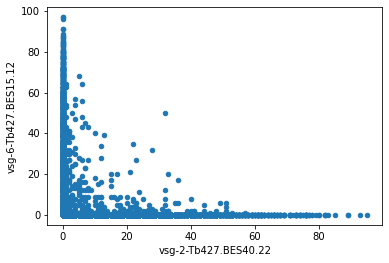

In [65]:
df.T.plot(x='vsg-2-Tb427.BES40.22',y='vsg-6-Tb427.BES15.12',kind='scatter')

<AxesSubplot:xlabel='vsg-2-Tb427.BES40.22', ylabel='vsg-6-Tb427.BES15.12'>

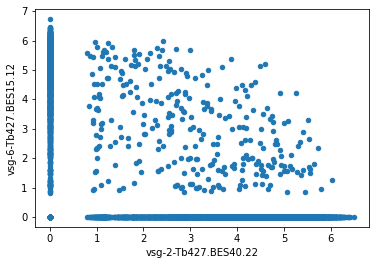

In [66]:
df = pd.read_csv(path_to+"decont_dense_log_vsg.csv")
df.T.plot(x='vsg-2-Tb427.BES40.22', y='vsg-6-Tb427.BES15.12',kind='scatter')

In [67]:
df.T[df.T['vsg-2-Tb427.BES40.22']==0].shape

(1842, 22)

In [68]:
df.head()

,AAACCCAAGCGTGCTC-1,AAACCCACAATGGCAG-1,AAACCCACAGAACCGA-1,AAACCCACATGCCATA-1,AAACCCAGTAACCAGG-1,AAACCCATCACTAGCA-1,AAACCCATCTGATGGT-1,AAACGAACAATGTGGG-1,AAACGAACAGTCGGTC-1,AAACGAAGTTGTAGCT-1,...,TTTGGTTCAAGTGCAG-1,TTTGGTTGTGAGCAGT-1,TTTGGTTTCACTACGA-1,TTTGGTTTCAGTGCGC-1,TTTGGTTTCGAATGCT-1,TTTGTTGAGTCGGCCT-1,TTTGTTGCAAGACTGG-1,TTTGTTGCACATACGT-1,TTTGTTGCATAGCACT-1,TTTGTTGGTCCCGGTA-1
vsg-2-Tb427.BES40.22,5.771588,0.000000,5.190335,4.13093,0.000000,2.253749,4.424309,4.564359,5.190475,3.403627,...,3.046631,5.715908,3.672065,4.124424,1.96256,0.000000,0,3.034806,4.908545,4.009613
vsg-9-Tb427.BES129.14,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0,0.000000,0.000000,0.000000
vsg-6-Tb427.BES15.12,0.000000,5.609384,0.000000,0.00000,5.354103,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,5.256035,0,0.000000,0.000000,0.000000
vsg-21-Tb427.BES28.15,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0,0.000000,0.000000,0.000000
vsg-18-Tb427.BES98.12,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0,0.000000,0.000000,0.000000


In [69]:
#fold_change = df.T['vsg-2-Tb427.BES40.22'] - df.T['vsg-6-Tb427.BES4.11']
#fold_change.sort_values().plot()

In [70]:
#df[df>10]=0
#df.T.head()

In [71]:
#df[df>1]=1
#df.T.head()

In [72]:
#df.sum(axis=1)>1

In [73]:
#import missingno as msno
#import numpy as np
#msno.matrix(df.replace(0, np.nan))


<AxesSubplot:>

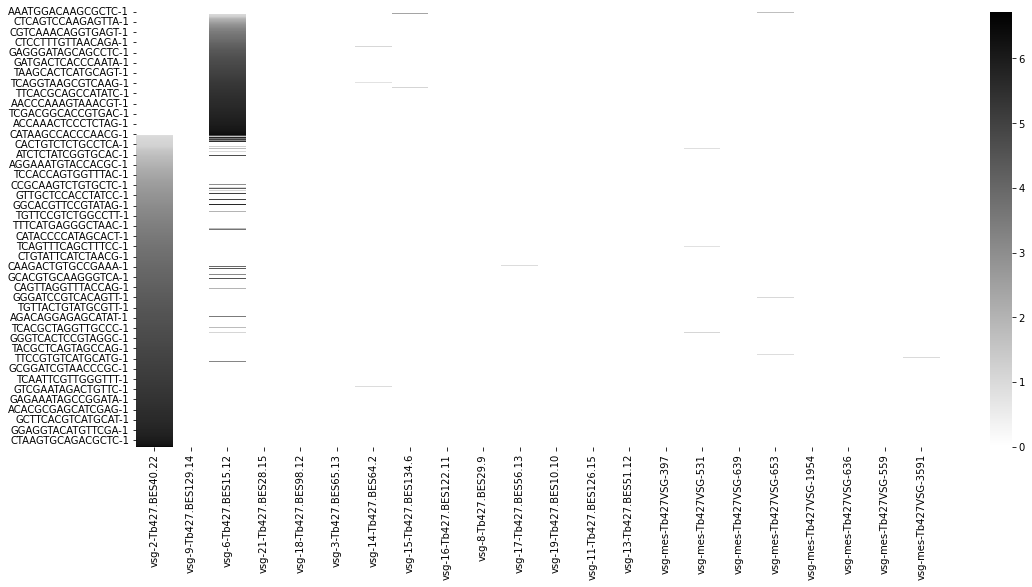

In [74]:
fig,ax=plt.subplots(figsize=(18,8))
sns.heatmap(df.T[df.T.sum(axis=1)>1].sort_values(
    ['vsg-2-Tb427.BES40.22','vsg-6-Tb427.BES15.12']),cmap='binary',ax=ax)

In [75]:
df.T[df.T.sum(axis=1)>1].shape

(4219, 22)

In [76]:
temp = df.loc[['vsg-2-Tb427.BES40.22','vsg-6-Tb427.BES15.12']]
temp = temp.T
temp = temp[temp.sum(axis=1)>1]
temp.shape

(4194, 2)

In [77]:
temp.head()

,vsg-2-Tb427.BES40.22,vsg-6-Tb427.BES15.12
AAACCCAAGCGTGCTC-1,5.771588,0.000000
AAACCCACAATGGCAG-1,0.000000,5.609384
AAACCCACAGAACCGA-1,5.190335,0.000000
AAACCCACATGCCATA-1,4.130930,0.000000
AAACCCAGTAACCAGG-1,0.000000,5.354103


In [78]:
temp[temp>0]=1
temp.head()

,vsg-2-Tb427.BES40.22,vsg-6-Tb427.BES15.12
AAACCCAAGCGTGCTC-1,1.0,0.0
AAACCCACAATGGCAG-1,0.0,1.0
AAACCCACAGAACCGA-1,1.0,0.0
AAACCCACATGCCATA-1,1.0,0.0
AAACCCAGTAACCAGG-1,0.0,1.0


In [79]:
temp.value_counts()

vsg-2-Tb427.BES40.22  vsg-6-Tb427.BES15.12
1.0                   0.0                     2723
0.0                   1.0                     1173
1.0                   1.0                      298
dtype: int64

In [80]:
(298/(1173+2723)*100)

7.648870636550307